In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/home/florpi/JUNE-private/data
No --configs argument given - defaulting to:
/home/florpi/JUNE-private/june/configs


2021-10-28 12:17:57,450 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/florpi/UNGP-settlement-modelling-private/camp_data
2021-10-28 12:17:57,451 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/florpi/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [5]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2021-10-28 12:17:57,892 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [6]:
# populate empty world
populate_world(world)

In [7]:
# distribute people to households
distribute_people_to_households(world)

In [8]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2021-10-28 12:17:58,697 - hospitals - INFO - There are 8 hospitals in the world.


In [9]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2021-10-28 12:17:58,755 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2021-10-28 12:17:58,797 - social_venue - INFO - Domain 0 has 506 play_groups(s)
2021-10-28 12:17:58,811 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2021-10-28 12:17:58,862 - social_venue - INFO - Domain 0 has 125 communals(s)
2021-10-28 12:17:58,897 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2021-10-28 12:17:59,468 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2021-10-28 12:17:59,477 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2021-10-28 12:17:59,489 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [10]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['f', 'm', 'f', 'm', 'f'], [33, 54, 34, 61, 27])

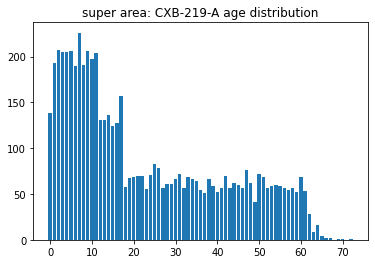

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 48%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

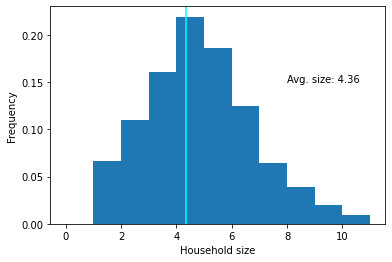

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [20]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

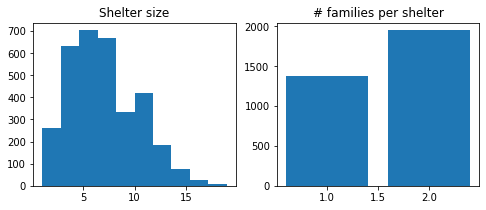

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [22]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [23]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [24]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [25]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [26]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [27]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [28]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [29]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [30]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [31]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [32]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [33]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [34]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [35]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [36]:
selector = InfectionSelector.from_file()

In [37]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [38]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [39]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [40]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [41]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [42]:
infection_seeds = InfectionSeeds([infection_seed])

In [43]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path=camp_configs_path / "defaults/comorbidities.yaml",
    male_comorbidity_reference_prevalence_path= camp_data_path / "input/demography/uk_male_comorbidities.csv",
    female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv",
    
)

In [44]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [45]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [46]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2021-10-28 12:18:11,605 - leisure - INFO - Linking households and care homes for visits
2021-10-28 12:18:11,606 - leisure - INFO - Done
2021-10-28 12:18:11,607 - leisure - INFO - Distributing social venues to areas
2021-10-28 12:18:11,607 - leisure - INFO - Distributed in 0 of 65 areas.
2021-10-28 12:18:11,739 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [47]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [48]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [49]:
%%time
simulator.run()

2021-10-28 12:18:13,735 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2021-10-28 12:18:14,215 - rank - INFO - Next timestep
2021-10-28 12:18:14,215 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:14,394 - rank - INFO - Rank 0 -- move_people -- 0.1784799050001311
2021-10-28 12:18:14,395 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7009958759881556e-06
2021-10-28 12:18:14,396 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.303001333028078e-06,4.0531158447265625e-06 - 2020-05-24 00:00:00
2021-10-28 12:18:14,401 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 222
2021-10-28 12:18:14,508 - rank - INFO - Rank 0 -- interaction -- 0.11161294399789767
2021-10-28 12:18:14,516 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.007020363998890389,0.0070209503173828125 - 2020-05-24 00:00:00
2021-10-28 12:18:14,

2021-10-28 12:18:19,323 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 258
2021-10-28 12:18:19,548 - rank - INFO - Rank 0 -- interaction -- 0.23809161499957554
2021-10-28 12:18:19,551 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019672200141940266,0.00019693374633789062 - 2020-05-25 02:00:00
2021-10-28 12:18:19,591 - rank - INFO - Rank 0 -- interaction_waiting -- 3.287997969891876e-06
2021-10-28 12:18:19,611 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.019567307994293515,0.01956915855407715 - 2020-05-25 02:00:00

2021-10-28 12:18:19,616 - rank - INFO - Next timestep
2021-10-28 12:18:19,619 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:20,120 - rank - INFO - Rank 0 -- move_people -- 0.4983665910040145
2021-10-28 12:18:20,120 - rank - INFO - Rank 0 -- move_people_waiting -- 4.194000212009996e-06
2021-10-28 12:18:20,121 - activity_manager - INFO - CMS: Peop

2021-10-28 12:18:24,184 - rank - INFO - Next timestep
2021-10-28 12:18:24,184 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:24,667 - rank - INFO - Rank 0 -- move_people -- 0.482304147000832
2021-10-28 12:18:24,668 - rank - INFO - Rank 0 -- move_people_waiting -- 4.016001184936613e-06
2021-10-28 12:18:24,669 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.498004273045808e-06,4.0531158447265625e-06 - 2020-05-26 06:00:00
2021-10-28 12:18:24,674 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 349
2021-10-28 12:18:24,805 - rank - INFO - Rank 0 -- interaction -- 0.1355481159989722
2021-10-28 12:18:24,809 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003222379964427091,0.00032210350036621094 - 2020-05-26 06:00:00
2021-10-28 12:18:24,842 - rank - INFO - Rank 0 -- interaction_waiting -- 4.353001713752747e-06
2021-10-28 12:18:24,868 - simulator - INFO - CMS: T

2021-10-28 12:18:29,250 - rank - INFO - Rank 0 -- interaction -- 0.15797556200413965
2021-10-28 12:18:29,254 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022324799647321925,0.00022292137145996094 - 2020-05-27 08:00:00
2021-10-28 12:18:29,303 - rank - INFO - Rank 0 -- interaction_waiting -- 3.832996299024671e-06
2021-10-28 12:18:29,314 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011520685999130365,0.0115203857421875 - 2020-05-27 08:00:00

2021-10-28 12:18:29,316 - rank - INFO - Next timestep
2021-10-28 12:18:29,316 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:29,487 - rank - INFO - Rank 0 -- move_people -- 0.17075893199944403
2021-10-28 12:18:29,488 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7330028135329485e-06
2021-10-28 12:18:29,489 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.5150009100325406e-06,4.5299530029296875e-06 - 2020-05-27 10:00:00
2021-10-28 12:18:29,494 - simulator - INFO - I

2021-10-28 12:18:33,482 - rank - INFO - Rank 0 -- move_people -- 0.21412465700268513
2021-10-28 12:18:33,483 - rank - INFO - Rank 0 -- move_people_waiting -- 4.854999133385718e-06
2021-10-28 12:18:33,483 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5240009310655296e-06,3.5762786865234375e-06 - 2020-05-29 00:00:00
2021-10-28 12:18:33,488 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 678
2021-10-28 12:18:33,571 - rank - INFO - Rank 0 -- interaction -- 0.08698360000562388
2021-10-28 12:18:33,578 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019964300008723512,0.00019979476928710938 - 2020-05-29 00:00:00
2021-10-28 12:18:33,622 - rank - INFO - Rank 0 -- interaction_waiting -- 1.8974998965859413e-05
2021-10-28 12:18:33,633 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011153143001138233,0.011152982711791992 - 2020-05-29 00:00:00

2021-10-28 12:18:33,635 - rank - INFO - Next timestep
20

2021-10-28 12:18:37,903 - rank - INFO - Rank 0 -- interaction_waiting -- 3.441993612796068e-06
2021-10-28 12:18:37,918 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015133955996134318,0.015135049819946289 - 2020-05-30 03:00:00

2021-10-28 12:18:37,919 - rank - INFO - Next timestep
2021-10-28 12:18:37,920 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:38,391 - rank - INFO - Rank 0 -- move_people -- 0.4705303099981393
2021-10-28 12:18:38,392 - rank - INFO - Rank 0 -- move_people_waiting -- 7.001995982136577e-06
2021-10-28 12:18:38,392 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.134999810252339e-06,4.5299530029296875e-06 - 2020-05-30 05:00:00
2021-10-28 12:18:38,399 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 872
2021-10-28 12:18:38,563 - rank - INFO - Rank 0 -- interaction -- 0.17033921999973245
2021-10-28 12:18:38,568 - epidemiology - INFO - CMS: Infection 

2021-10-28 12:18:42,965 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1046
2021-10-28 12:18:43,146 - rank - INFO - Rank 0 -- interaction -- 0.18705577999935485
2021-10-28 12:18:43,157 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004601849941536784,0.00045943260192871094 - 2020-05-31 07:00:00
2021-10-28 12:18:43,240 - rank - INFO - Rank 0 -- interaction_waiting -- 9.274997864849865e-06
2021-10-28 12:18:43,270 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.030045218001760077,0.030045747756958008 - 2020-05-31 07:00:00

2021-10-28 12:18:43,273 - rank - INFO - Next timestep
2021-10-28 12:18:43,274 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:43,894 - rank - INFO - Rank 0 -- move_people -- 0.6166333330038469
2021-10-28 12:18:43,894 - rank - INFO - Rank 0 -- move_people_waiting -- 6.759997631888837e-06
2021-10-28 12:18:43,895 - activity_manager - INFO - CMS: Peo

2021-10-28 12:18:48,487 - rank - INFO - Next timestep
2021-10-28 12:18:48,487 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:48,731 - rank - INFO - Rank 0 -- move_people -- 0.24279851600294933
2021-10-28 12:18:48,732 - rank - INFO - Rank 0 -- move_people_waiting -- 4.699999408330768e-06
2021-10-28 12:18:48,732 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.276997399050742e-06,5.0067901611328125e-06 - 2020-06-01 10:00:00
2021-10-28 12:18:48,738 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1216
2021-10-28 12:18:48,853 - rank - INFO - Rank 0 -- interaction -- 0.12010144099622266
2021-10-28 12:18:48,883 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022181600070325658,0.00022149085998535156 - 2020-06-01 10:00:00
2021-10-28 12:18:48,939 - rank - INFO - Rank 0 -- interaction_waiting -- 3.3760006772354245e-06
2021-10-28 12:18:48,953 - simulator - INFO - 

2021-10-28 12:18:53,373 - rank - INFO - Rank 0 -- interaction -- 0.12106720299925655
2021-10-28 12:18:53,381 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021548999939113855,0.00021529197692871094 - 2020-06-03 00:00:00
2021-10-28 12:18:53,428 - rank - INFO - Rank 0 -- interaction_waiting -- 5.499001417774707e-06
2021-10-28 12:18:53,441 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013203911999880802,0.013207435607910156 - 2020-06-03 00:00:00

2021-10-28 12:18:53,447 - rank - INFO - Next timestep
2021-10-28 12:18:53,452 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:18:54,036 - rank - INFO - Rank 0 -- move_people -- 0.5822529139986727
2021-10-28 12:18:54,036 - rank - INFO - Rank 0 -- move_people_waiting -- 5.019996024202555e-06
2021-10-28 12:18:54,037 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3819960663095117e-06,3.0994415283203125e-06 - 2020-06-03 02:00:00
2021-10-28 12:18:54,042 - simulator - INFO - I

2021-10-28 12:18:59,406 - rank - INFO - Rank 0 -- move_people -- 0.5556331710031372
2021-10-28 12:18:59,406 - rank - INFO - Rank 0 -- move_people_waiting -- 5.636000423692167e-06
2021-10-28 12:18:59,407 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.610999894794077e-06,4.291534423828125e-06 - 2020-06-04 04:00:00
2021-10-28 12:18:59,413 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 1635
2021-10-28 12:18:59,654 - rank - INFO - Rank 0 -- interaction -- 0.246625446001417
2021-10-28 12:18:59,662 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023345400404650718,0.00023365020751953125 - 2020-06-04 04:00:00
2021-10-28 12:18:59,720 - rank - INFO - Rank 0 -- interaction_waiting -- 3.4810000215657055e-06
2021-10-28 12:18:59,729 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009481398003117647,0.009482145309448242 - 2020-06-04 04:00:00

2021-10-28 12:18:59,731 - rank - INFO - Next timestep
2021-1

2021-10-28 12:19:04,591 - rank - INFO - Rank 0 -- interaction_waiting -- 3.4329932532273233e-06
2021-10-28 12:19:04,602 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011019626996130683,0.011020183563232422 - 2020-06-05 06:00:00

2021-10-28 12:19:04,604 - rank - INFO - Next timestep
2021-10-28 12:19:04,605 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:05,338 - rank - INFO - Rank 0 -- move_people -- 0.7333524679997936
2021-10-28 12:19:05,339 - rank - INFO - Rank 0 -- move_people_waiting -- 8.615003025624901e-06
2021-10-28 12:19:05,343 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.572997568175197e-06,4.0531158447265625e-06 - 2020-06-05 08:00:00
2021-10-28 12:19:05,350 - simulator - INFO - Info for rank 0, Date = 2020-06-05 08:00:00, number of deaths =  0, number of infected = 1826
2021-10-28 12:19:05,607 - rank - INFO - Rank 0 -- interaction -- 0.2635579849957139
2021-10-28 12:19:05,621 - epidemiology - INFO - CMS: Infection

2021-10-28 12:19:10,197 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 2013
2021-10-28 12:19:10,298 - rank - INFO - Rank 0 -- interaction -- 0.10568276499543572
2021-10-28 12:19:10,330 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004711239962489344,0.00047087669372558594 - 2020-06-06 11:00:00
2021-10-28 12:19:10,370 - rank - INFO - Rank 0 -- interaction_waiting -- 3.4819968277588487e-06
2021-10-28 12:19:10,382 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01189852199604502,0.01189875602722168 - 2020-06-06 11:00:00

2021-10-28 12:19:10,383 - rank - INFO - Next timestep
2021-10-28 12:19:10,384 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:10,563 - rank - INFO - Rank 0 -- move_people -- 0.1780365869999514
2021-10-28 12:19:10,564 - rank - INFO - Rank 0 -- move_people_waiting -- 6.260997906792909e-06
2021-10-28 12:19:10,564 - activity_manager - INFO - CMS: Peop

2021-10-28 12:19:14,485 - rank - INFO - Next timestep
2021-10-28 12:19:14,486 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:14,959 - rank - INFO - Rank 0 -- move_people -- 0.47088839799835114
2021-10-28 12:19:14,959 - rank - INFO - Rank 0 -- move_people_waiting -- 6.491005478892475e-06
2021-10-28 12:19:14,960 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.314002919476479e-06,4.76837158203125e-06 - 2020-06-08 02:00:00
2021-10-28 12:19:14,968 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 2268
2021-10-28 12:19:15,182 - rank - INFO - Rank 0 -- interaction -- 0.22159893700154498
2021-10-28 12:19:15,191 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023027200222713873,0.00022983551025390625 - 2020-06-08 02:00:00
2021-10-28 12:19:15,236 - rank - INFO - Rank 0 -- interaction_waiting -- 3.7150020943954587e-06
2021-10-28 12:19:15,246 - simulator - INFO - CM

2021-10-28 12:19:20,170 - rank - INFO - Rank 0 -- interaction -- 0.1893249300046591
2021-10-28 12:19:20,176 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024775799829512835,0.00024771690368652344 - 2020-06-09 04:00:00
2021-10-28 12:19:20,223 - rank - INFO - Rank 0 -- interaction_waiting -- 3.7860008887946606e-06
2021-10-28 12:19:20,233 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010224536003079265,0.01022481918334961 - 2020-06-09 04:00:00

2021-10-28 12:19:20,235 - rank - INFO - Next timestep
2021-10-28 12:19:20,236 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:20,712 - rank - INFO - Rank 0 -- move_people -- 0.4753161150001688
2021-10-28 12:19:20,713 - rank - INFO - Rank 0 -- move_people_waiting -- 4.134999471716583e-06
2021-10-28 12:19:20,714 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.577995812520385e-06,2.86102294921875e-06 - 2020-06-09 06:00:00
2021-10-28 12:19:20,719 - simulator - INFO - Info 

2021-10-28 12:19:25,659 - rank - INFO - Rank 0 -- move_people -- 0.514874738000799
2021-10-28 12:19:25,660 - rank - INFO - Rank 0 -- move_people_waiting -- 5.6100034271366894e-06
2021-10-28 12:19:25,660 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.811001417692751e-06,4.5299530029296875e-06 - 2020-06-10 08:00:00
2021-10-28 12:19:25,666 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  0, number of infected = 2623
2021-10-28 12:19:25,841 - rank - INFO - Rank 0 -- interaction -- 0.1804111519959406
2021-10-28 12:19:25,849 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029237099806778133,0.00029277801513671875 - 2020-06-10 08:00:00
2021-10-28 12:19:25,894 - rank - INFO - Rank 0 -- interaction_waiting -- 4.162997356615961e-06
2021-10-28 12:19:25,904 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0098112619962194,0.009812355041503906 - 2020-06-10 08:00:00

2021-10-28 12:19:25,905 - rank - INFO - Next timestep
2021-10

2021-10-28 12:19:31,564 - rank - INFO - Rank 0 -- interaction_waiting -- 3.401997673790902e-06
2021-10-28 12:19:31,574 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010752868998679332,0.010753631591796875 - 2020-06-11 10:00:00

2021-10-28 12:19:31,576 - rank - INFO - Next timestep
2021-10-28 12:19:31,576 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:31,777 - rank - INFO - Rank 0 -- move_people -- 0.19992965100391302
2021-10-28 12:19:31,777 - rank - INFO - Rank 0 -- move_people_waiting -- 4.213994543533772e-06
2021-10-28 12:19:31,778 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.194000550545752e-06,4.76837158203125e-06 - 2020-06-12 00:00:00
2021-10-28 12:19:31,784 - simulator - INFO - Info for rank 0, Date = 2020-06-12 00:00:00, number of deaths =  0, number of infected = 2865
2021-10-28 12:19:31,900 - rank - INFO - Rank 0 -- interaction -- 0.12154412300151307
2021-10-28 12:19:31,908 - epidemiology - INFO - CMS: Infection 

2021-10-28 12:19:37,830 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  0, number of infected = 3026
2021-10-28 12:19:38,035 - rank - INFO - Rank 0 -- interaction -- 0.21303210699988995
2021-10-28 12:19:38,041 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022119699860922992,0.00022077560424804688 - 2020-06-13 03:00:00
2021-10-28 12:19:38,103 - rank - INFO - Rank 0 -- interaction_waiting -- 3.6849960451945662e-06
2021-10-28 12:19:38,114 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010465864994330332,0.010466575622558594 - 2020-06-13 03:00:00

2021-10-28 12:19:38,115 - rank - INFO - Next timestep
2021-10-28 12:19:38,116 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:38,687 - rank - INFO - Rank 0 -- move_people -- 0.5699396960044396
2021-10-28 12:19:38,687 - rank - INFO - Rank 0 -- move_people_waiting -- 6.075002602301538e-06
2021-10-28 12:19:38,688 - activity_manager - INFO - CMS: P

2021-10-28 12:19:43,678 - rank - INFO - Next timestep
2021-10-28 12:19:43,679 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:44,179 - rank - INFO - Rank 0 -- move_people -- 0.4997517970041372
2021-10-28 12:19:44,180 - rank - INFO - Rank 0 -- move_people_waiting -- 7.0829992182552814e-06
2021-10-28 12:19:44,180 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.8869991335086524e-06,5.4836273193359375e-06 - 2020-06-14 07:00:00
2021-10-28 12:19:44,188 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  0, number of infected = 3198
2021-10-28 12:19:44,391 - rank - INFO - Rank 0 -- interaction -- 0.20948113900522003
2021-10-28 12:19:44,399 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001780969978426583,0.00017786026000976562 - 2020-06-14 07:00:00
2021-10-28 12:19:44,452 - rank - INFO - Rank 0 -- interaction_waiting -- 1.4336001186165959e-05
2021-10-28 12:19:44,471 - simulator - INFO - 

2021-10-28 12:19:49,345 - rank - INFO - Rank 0 -- interaction -- 0.2523786269957782
2021-10-28 12:19:49,353 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00031366600160254166,0.00031280517578125 - 2020-06-15 08:00:00
2021-10-28 12:19:49,437 - rank - INFO - Rank 0 -- interaction_waiting -- 4.230001650284976e-06
2021-10-28 12:19:49,447 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010038880005595274,0.010039329528808594 - 2020-06-15 08:00:00

2021-10-28 12:19:49,449 - rank - INFO - Next timestep
2021-10-28 12:19:49,450 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:19:49,659 - rank - INFO - Rank 0 -- move_people -- 0.2088870980005595
2021-10-28 12:19:49,660 - rank - INFO - Rank 0 -- move_people_waiting -- 6.2489998526871204e-06
2021-10-28 12:19:49,661 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.950001311954111e-06,4.291534423828125e-06 - 2020-06-15 10:00:00
2021-10-28 12:19:49,667 - simulator - INFO - Info f

2021-10-28 12:19:54,612 - rank - INFO - Rank 0 -- move_people -- 0.26683139400120126
2021-10-28 12:19:54,612 - rank - INFO - Rank 0 -- move_people_waiting -- 6.371999916154891e-06
2021-10-28 12:19:54,613 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.84000304620713e-06,3.5762786865234375e-06 - 2020-06-17 00:00:00
2021-10-28 12:19:54,619 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  0, number of infected = 3524
2021-10-28 12:19:54,732 - rank - INFO - Rank 0 -- interaction -- 0.11895931399340043
2021-10-28 12:19:54,737 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020263599435565993,0.00020241737365722656 - 2020-06-17 00:00:00
2021-10-28 12:19:54,787 - rank - INFO - Rank 0 -- interaction_waiting -- 4.1099992813542485e-06
2021-10-28 12:19:54,797 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010605785995721817,0.010605812072753906 - 2020-06-17 00:00:00

2021-10-28 12:19:54,799 - rank - INFO - Next timestep
202

2021-10-28 12:20:00,555 - rank - INFO - Rank 0 -- interaction_waiting -- 6.246002158150077e-06
2021-10-28 12:20:00,579 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.02396935100114206,0.023971080780029297 - 2020-06-18 02:00:00

2021-10-28 12:20:00,581 - rank - INFO - Next timestep
2021-10-28 12:20:00,581 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:01,080 - rank - INFO - Rank 0 -- move_people -- 0.4977432220039191
2021-10-28 12:20:01,081 - rank - INFO - Rank 0 -- move_people_waiting -- 4.396999429445714e-06
2021-10-28 12:20:01,082 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7909994716756046e-06,3.5762786865234375e-06 - 2020-06-18 04:00:00
2021-10-28 12:20:01,088 - simulator - INFO - Info for rank 0, Date = 2020-06-18 04:00:00, number of deaths =  0, number of infected = 3638
2021-10-28 12:20:01,272 - rank - INFO - Rank 0 -- interaction -- 0.1895724540008814
2021-10-28 12:20:01,286 - epidemiology - INFO - CMS: Infection 

2021-10-28 12:20:06,943 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.980000423733145e-06,5.4836273193359375e-06 - 2020-06-19 06:00:00
2021-10-28 12:20:06,949 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  1, number of infected = 3723
2021-10-28 12:20:07,315 - rank - INFO - Rank 0 -- interaction -- 0.3712027389992727
2021-10-28 12:20:07,325 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002990869979839772,0.0002987384796142578 - 2020-06-19 06:00:00
2021-10-28 12:20:07,383 - rank - INFO - Rank 0 -- interaction_waiting -- 4.212997737340629e-06
2021-10-28 12:20:07,394 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010854937994736247,0.010855674743652344 - 2020-06-19 06:00:00

2021-10-28 12:20:07,395 - rank - INFO - Next timestep
2021-10-28 12:20:07,396 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:08,028 - rank - INFO - Rank 0 -- move_people -- 0.6312920330019551
2021-1

2021-10-28 12:20:19,043 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.029992121002578642,0.02999281883239746 - 2020-06-20 09:00:00

2021-10-28 12:20:19,050 - rank - INFO - Next timestep
2021-10-28 12:20:19,051 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:19,647 - rank - INFO - Rank 0 -- move_people -- 0.5943973569956142
2021-10-28 12:20:19,648 - rank - INFO - Rank 0 -- move_people_waiting -- 2.8410067898221314e-06
2021-10-28 12:20:19,650 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.868001269642264e-06,4.5299530029296875e-06 - 2020-06-20 11:00:00
2021-10-28 12:20:19,662 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  1, number of infected = 3849
2021-10-28 12:20:20,078 - rank - INFO - Rank 0 -- interaction -- 0.4269622319989139
2021-10-28 12:20:20,241 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018910800281446427,0.00018858909606933594 - 2020-06-20 11:00:00
2021

2021-10-28 12:20:30,394 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  1, number of infected = 3968
2021-10-28 12:20:30,583 - rank - INFO - Rank 0 -- interaction -- 0.19880355200439226
2021-10-28 12:20:30,590 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023847599368309602,0.00023818016052246094 - 2020-06-22 00:00:00
2021-10-28 12:20:30,654 - rank - INFO - Rank 0 -- interaction_waiting -- 4.130000888835639e-06
2021-10-28 12:20:30,664 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010512032997212373,0.010512590408325195 - 2020-06-22 00:00:00

2021-10-28 12:20:30,666 - rank - INFO - Next timestep
2021-10-28 12:20:30,668 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:31,266 - rank - INFO - Rank 0 -- move_people -- 0.5972996030031936
2021-10-28 12:20:31,266 - rank - INFO - Rank 0 -- move_people_waiting -- 7.681999704800546e-06
2021-10-28 12:20:31,267 - activity_manager - INFO - CMS: Pe

2021-10-28 12:20:37,696 - rank - INFO - Next timestep
2021-10-28 12:20:37,697 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:38,574 - rank - INFO - Rank 0 -- move_people -- 0.8758520520059392
2021-10-28 12:20:38,577 - rank - INFO - Rank 0 -- move_people_waiting -- 9.847994078882039e-06
2021-10-28 12:20:38,579 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.04500382905826e-06,5.4836273193359375e-06 - 2020-06-23 04:00:00
2021-10-28 12:20:38,589 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  1, number of infected = 4048
2021-10-28 12:20:38,919 - rank - INFO - Rank 0 -- interaction -- 0.33991817599599017
2021-10-28 12:20:38,933 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002649410016601905,0.0002644062042236328 - 2020-06-23 04:00:00
2021-10-28 12:20:39,036 - rank - INFO - Rank 0 -- interaction_waiting -- 5.637004505842924e-06
2021-10-28 12:20:39,059 - simulator - INFO - CMS: 

2021-10-28 12:20:45,679 - rank - INFO - Rank 0 -- interaction -- 0.23622364999755519
2021-10-28 12:20:45,686 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018899599672295153,0.0001888275146484375 - 2020-06-24 06:00:00
2021-10-28 12:20:45,745 - rank - INFO - Rank 0 -- interaction_waiting -- 4.109002475161105e-06
2021-10-28 12:20:45,755 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010460012999828905,0.010460376739501953 - 2020-06-24 06:00:00

2021-10-28 12:20:45,757 - rank - INFO - Next timestep
2021-10-28 12:20:45,758 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:46,401 - rank - INFO - Rank 0 -- move_people -- 0.6417128799948841
2021-10-28 12:20:46,401 - rank - INFO - Rank 0 -- move_people_waiting -- 5.290996341500431e-06
2021-10-28 12:20:46,402 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.576999683398753e-06,5.4836273193359375e-06 - 2020-06-24 08:00:00
2021-10-28 12:20:46,409 - simulator - INFO - Inf

2021-10-28 12:20:52,510 - rank - INFO - Rank 0 -- move_people -- 0.36483727100130636
2021-10-28 12:20:52,510 - rank - INFO - Rank 0 -- move_people_waiting -- 5.731999408453703e-06
2021-10-28 12:20:52,511 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.256005922798067e-06,3.814697265625e-06 - 2020-06-25 10:00:00
2021-10-28 12:20:52,519 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  1, number of infected = 4173
2021-10-28 12:20:52,704 - rank - INFO - Rank 0 -- interaction -- 0.192213467998954
2021-10-28 12:20:52,779 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018217999604530632,0.00018167495727539062 - 2020-06-25 10:00:00
2021-10-28 12:20:52,842 - rank - INFO - Rank 0 -- interaction_waiting -- 4.078006895724684e-06
2021-10-28 12:20:52,853 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011152552004205063,0.01115274429321289 - 2020-06-25 10:00:00

2021-10-28 12:20:52,855 - rank - INFO - Next timestep
2021-10-28

2021-10-28 12:20:57,917 - rank - INFO - Rank 0 -- interaction_waiting -- 4.089000867679715e-06
2021-10-28 12:20:57,928 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011047323998354841,0.011047840118408203 - 2020-06-27 00:00:00

2021-10-28 12:20:57,930 - rank - INFO - Next timestep
2021-10-28 12:20:57,931 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:20:58,411 - rank - INFO - Rank 0 -- move_people -- 0.4791150040036882
2021-10-28 12:20:58,412 - rank - INFO - Rank 0 -- move_people_waiting -- 5.740999768022448e-06
2021-10-28 12:20:58,412 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.6389977796934545e-06,4.291534423828125e-06 - 2020-06-27 03:00:00
2021-10-28 12:20:58,421 - simulator - INFO - Info for rank 0, Date = 2020-06-27 03:00:00, number of deaths =  1, number of infected = 4274
2021-10-28 12:20:58,633 - rank - INFO - Rank 0 -- interaction -- 0.2202068379992852
2021-10-28 12:20:58,642 - epidemiology - INFO - CMS: Infection 

2021-10-28 12:21:03,833 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  1, number of infected = 4378
2021-10-28 12:21:04,046 - rank - INFO - Rank 0 -- interaction -- 0.21937365200574277
2021-10-28 12:21:04,062 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021477099653566256,0.00021457672119140625 - 2020-06-28 05:00:00
2021-10-28 12:21:04,119 - rank - INFO - Rank 0 -- interaction_waiting -- 3.7670033634640276e-06
2021-10-28 12:21:04,129 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010515523004869465,0.01051640510559082 - 2020-06-28 05:00:00

2021-10-28 12:21:04,131 - rank - INFO - Next timestep
2021-10-28 12:21:04,132 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:04,644 - rank - INFO - Rank 0 -- move_people -- 0.5111024150028243
2021-10-28 12:21:04,644 - rank - INFO - Rank 0 -- move_people_waiting -- 6.356000085361302e-06
2021-10-28 12:21:04,645 - activity_manager - INFO - CMS: Pe

2021-10-28 12:21:09,612 - rank - INFO - Next timestep
2021-10-28 12:21:09,613 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:10,310 - rank - INFO - Rank 0 -- move_people -- 0.6953600459964946
2021-10-28 12:21:10,310 - rank - INFO - Rank 0 -- move_people_waiting -- 7.308997737709433e-06
2021-10-28 12:21:10,311 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.645997250918299e-06,4.0531158447265625e-06 - 2020-06-29 08:00:00
2021-10-28 12:21:10,317 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  1, number of infected = 4438
2021-10-28 12:21:10,543 - rank - INFO - Rank 0 -- interaction -- 0.2312304720035172
2021-10-28 12:21:10,552 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027626600058283657,0.0002760887145996094 - 2020-06-29 08:00:00
2021-10-28 12:21:10,610 - rank - INFO - Rank 0 -- interaction_waiting -- 4.737004928756505e-06
2021-10-28 12:21:10,621 - simulator - INFO - CMS:

2021-10-28 12:21:15,743 - rank - INFO - Rank 0 -- interaction -- 0.17465926600561943
2021-10-28 12:21:15,794 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020644700271077454,0.00020599365234375 - 2020-06-30 10:00:00
2021-10-28 12:21:15,858 - rank - INFO - Rank 0 -- interaction_waiting -- 4.2439933167770505e-06
2021-10-28 12:21:15,868 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010411907998786774,0.01041269302368164 - 2020-06-30 10:00:00

2021-10-28 12:21:15,870 - rank - INFO - Next timestep
2021-10-28 12:21:15,870 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:16,085 - rank - INFO - Rank 0 -- move_people -- 0.21399035100330366
2021-10-28 12:21:16,086 - rank - INFO - Rank 0 -- move_people_waiting -- 5.289999535307288e-06
2021-10-28 12:21:16,086 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.560999852605164e-06,5.0067901611328125e-06 - 2020-07-01 00:00:00
2021-10-28 12:21:16,093 - simulator - INFO - Info

2021-10-28 12:21:21,106 - rank - INFO - Rank 0 -- move_people -- 0.5296477709998726
2021-10-28 12:21:21,107 - rank - INFO - Rank 0 -- move_people_waiting -- 8.424001862294972e-06
2021-10-28 12:21:21,107 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.0780002968385816e-06,5.7220458984375e-06 - 2020-07-02 02:00:00
2021-10-28 12:21:21,114 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  1, number of infected = 4596
2021-10-28 12:21:21,334 - rank - INFO - Rank 0 -- interaction -- 0.22584098900551908
2021-10-28 12:21:21,342 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002458340022712946,0.0002455711364746094 - 2020-07-02 02:00:00
2021-10-28 12:21:21,418 - rank - INFO - Rank 0 -- interaction_waiting -- 3.8099969970062375e-06
2021-10-28 12:21:21,428 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009883158003503922,0.009883642196655273 - 2020-07-02 02:00:00

2021-10-28 12:21:21,430 - rank - INFO - Next timestep
2021-10

2021-10-28 12:21:26,389 - rank - INFO - Rank 0 -- interaction_waiting -- 1.6742000298108906e-05
2021-10-28 12:21:26,402 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012607835997187067,0.012604236602783203 - 2020-07-03 04:00:00

2021-10-28 12:21:26,403 - rank - INFO - Next timestep
2021-10-28 12:21:26,404 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:26,938 - rank - INFO - Rank 0 -- move_people -- 0.5324290500066127
2021-10-28 12:21:26,938 - rank - INFO - Rank 0 -- move_people_waiting -- 7.572001777589321e-06
2021-10-28 12:21:26,939 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.103000487200916e-06,5.4836273193359375e-06 - 2020-07-03 06:00:00
2021-10-28 12:21:26,946 - simulator - INFO - Info for rank 0, Date = 2020-07-03 06:00:00, number of deaths =  1, number of infected = 4620
2021-10-28 12:21:27,167 - rank - INFO - Rank 0 -- interaction -- 0.2268829029999324
2021-10-28 12:21:27,180 - epidemiology - INFO - CMS: Infection

2021-10-28 12:21:32,003 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7349964259192348e-06,3.337860107421875e-06 - 2020-07-04 09:00:00
2021-10-28 12:21:32,011 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  1, number of infected = 4668
2021-10-28 12:21:32,232 - rank - INFO - Rank 0 -- interaction -- 0.22858950000227196
2021-10-28 12:21:32,243 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00028410099912434816,0.00028395652770996094 - 2020-07-04 09:00:00
2021-10-28 12:21:32,305 - rank - INFO - Rank 0 -- interaction_waiting -- 3.5039993235841393e-06
2021-10-28 12:21:32,315 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010327807998692151,0.010328531265258789 - 2020-07-04 09:00:00

2021-10-28 12:21:32,317 - rank - INFO - Next timestep
2021-10-28 12:21:32,317 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:32,521 - rank - INFO - Rank 0 -- move_people -- 0.20260497099661734
2

2021-10-28 12:21:37,009 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012348989002930466,0.01234889030456543 - 2020-07-05 11:00:00

2021-10-28 12:21:37,011 - rank - INFO - Next timestep
2021-10-28 12:21:37,012 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:37,222 - rank - INFO - Rank 0 -- move_people -- 0.2091712839974207
2021-10-28 12:21:37,222 - rank - INFO - Rank 0 -- move_people_waiting -- 5.947003955952823e-06
2021-10-28 12:21:37,223 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.513997504953295e-06,5.9604644775390625e-06 - 2020-07-06 00:00:00
2021-10-28 12:21:37,233 - simulator - INFO - Info for rank 0, Date = 2020-07-06 00:00:00, number of deaths =  1, number of infected = 4689
2021-10-28 12:21:37,379 - rank - INFO - Rank 0 -- interaction -- 0.15516313999978593
2021-10-28 12:21:37,385 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002194800035795197,0.00021982192993164062 - 2020-07-06 00:00:00
2021-

2021-10-28 12:21:42,199 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  1, number of infected = 4764
2021-10-28 12:21:42,414 - rank - INFO - Rank 0 -- interaction -- 0.22423254499881295
2021-10-28 12:21:42,422 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023763199715176597,0.00023627281188964844 - 2020-07-07 02:00:00
2021-10-28 12:21:42,481 - rank - INFO - Rank 0 -- interaction_waiting -- 6.909998774062842e-06
2021-10-28 12:21:42,493 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011775389000831638,0.011775493621826172 - 2020-07-07 02:00:00

2021-10-28 12:21:42,495 - rank - INFO - Next timestep
2021-10-28 12:21:42,496 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:42,973 - rank - INFO - Rank 0 -- move_people -- 0.4767644029998337
2021-10-28 12:21:42,974 - rank - INFO - Rank 0 -- move_people_waiting -- 6.171998393256217e-06
2021-10-28 12:21:42,974 - activity_manager - INFO - CMS: Pe

2021-10-28 12:21:47,400 - rank - INFO - Next timestep
2021-10-28 12:21:47,401 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:47,888 - rank - INFO - Rank 0 -- move_people -- 0.4869068400003016
2021-10-28 12:21:47,889 - rank - INFO - Rank 0 -- move_people_waiting -- 3.741995897144079e-06
2021-10-28 12:21:47,890 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.8080033846199512e-06,3.5762786865234375e-06 - 2020-07-08 06:00:00
2021-10-28 12:21:47,899 - simulator - INFO - Info for rank 0, Date = 2020-07-08 06:00:00, number of deaths =  1, number of infected = 4806
2021-10-28 12:21:48,114 - rank - INFO - Rank 0 -- interaction -- 0.2233443619988975
2021-10-28 12:21:48,122 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00026699199952417985,0.00026679039001464844 - 2020-07-08 06:00:00
2021-10-28 12:21:48,183 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1242998880334198e-05
2021-10-28 12:21:48,193 - simulator - INFO - C

2021-10-28 12:21:53,227 - rank - INFO - Rank 0 -- interaction -- 0.23558935199980624
2021-10-28 12:21:53,236 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018633400031831115,0.0001857280731201172 - 2020-07-09 08:00:00
2021-10-28 12:21:53,298 - rank - INFO - Rank 0 -- interaction_waiting -- 4.009001713711768e-06
2021-10-28 12:21:53,308 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0102381270044134,0.010239839553833008 - 2020-07-09 08:00:00

2021-10-28 12:21:53,310 - rank - INFO - Next timestep
2021-10-28 12:21:53,310 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:21:53,508 - rank - INFO - Rank 0 -- move_people -- 0.19726932799676433
2021-10-28 12:21:53,509 - rank - INFO - Rank 0 -- move_people_waiting -- 6.012996891513467e-06
2021-10-28 12:21:53,510 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.264002200216055e-06,3.814697265625e-06 - 2020-07-09 10:00:00
2021-10-28 12:21:53,516 - simulator - INFO - Info for

2021-10-28 12:21:59,147 - rank - INFO - Rank 0 -- move_people -- 0.24212862699641846
2021-10-28 12:21:59,148 - rank - INFO - Rank 0 -- move_people_waiting -- 4.3149993871338665e-06
2021-10-28 12:21:59,148 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.551999493036419e-06,5.0067901611328125e-06 - 2020-07-11 00:00:00
2021-10-28 12:21:59,155 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  1, number of infected = 4908
2021-10-28 12:21:59,329 - rank - INFO - Rank 0 -- interaction -- 0.1803125629958231
2021-10-28 12:21:59,351 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00025044900394277647,0.00025010108947753906 - 2020-07-11 00:00:00
2021-10-28 12:21:59,411 - rank - INFO - Rank 0 -- interaction_waiting -- 3.6239944165572524e-06
2021-10-28 12:21:59,422 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010704245993110817,0.010704517364501953 - 2020-07-11 00:00:00

2021-10-28 12:21:59,424 - rank - INFO - Next timestep
20

2021-10-28 12:22:07,493 - rank - INFO - Rank 0 -- interaction_waiting -- 5.0629969337023795e-06
2021-10-28 12:22:07,514 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.021035028003097977,0.021034955978393555 - 2020-07-12 03:00:00

2021-10-28 12:22:07,517 - rank - INFO - Next timestep
2021-10-28 12:22:07,518 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:22:08,066 - rank - INFO - Rank 0 -- move_people -- 0.5475622489975649
2021-10-28 12:22:08,067 - rank - INFO - Rank 0 -- move_people_waiting -- 5.647998477797955e-06
2021-10-28 12:22:08,067 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.984001523349434e-06,3.814697265625e-06 - 2020-07-12 05:00:00
2021-10-28 12:22:08,073 - simulator - INFO - Info for rank 0, Date = 2020-07-12 05:00:00, number of deaths =  1, number of infected = 4896
2021-10-28 12:22:08,335 - rank - INFO - Rank 0 -- interaction -- 0.2671697569967364
2021-10-28 12:22:08,340 - epidemiology - INFO - CMS: Infection COM

2021-10-28 12:22:13,294 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  1, number of infected = 4887
2021-10-28 12:22:13,525 - rank - INFO - Rank 0 -- interaction -- 0.23721255200507585
2021-10-28 12:22:13,531 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00025370700313942507,0.00025391578674316406 - 2020-07-13 06:00:00
2021-10-28 12:22:13,593 - rank - INFO - Rank 0 -- interaction_waiting -- 3.980996552854776e-06
2021-10-28 12:22:13,603 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010253777996695135,0.010254144668579102 - 2020-07-13 06:00:00

2021-10-28 12:22:13,605 - rank - INFO - Next timestep
2021-10-28 12:22:13,606 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:22:14,228 - rank - INFO - Rank 0 -- move_people -- 0.6214438249953673
2021-10-28 12:22:14,229 - rank - INFO - Rank 0 -- move_people_waiting -- 7.51199695514515e-06
2021-10-28 12:22:14,230 - activity_manager - INFO - CMS: Peo

2021-10-28 12:22:19,711 - rank - INFO - Next timestep
2021-10-28 12:22:19,711 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:22:19,914 - rank - INFO - Rank 0 -- move_people -- 0.2025381589992321
2021-10-28 12:22:19,915 - rank - INFO - Rank 0 -- move_people_waiting -- 6.38399797026068e-06
2021-10-28 12:22:19,916 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.8960060919635e-06,3.5762786865234375e-06 - 2020-07-14 10:00:00
2021-10-28 12:22:19,922 - simulator - INFO - Info for rank 0, Date = 2020-07-14 10:00:00, number of deaths =  1, number of infected = 4877
2021-10-28 12:22:20,111 - rank - INFO - Rank 0 -- interaction -- 0.19429099699482322
2021-10-28 12:22:20,205 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016123200475703925,0.00016117095947265625 - 2020-07-14 10:00:00
2021-10-28 12:22:20,306 - rank - INFO - Rank 0 -- interaction_waiting -- 3.6569981602951884e-06
2021-10-28 12:22:20,329 - simulator - INFO - CMS:

2021-10-28 12:22:25,796 - rank - INFO - Rank 0 -- interaction -- 0.2426243930021883
2021-10-28 12:22:25,808 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002792390005197376,0.000278472900390625 - 2020-07-16 00:00:00
2021-10-28 12:22:25,870 - rank - INFO - Rank 0 -- interaction_waiting -- 3.688997821882367e-06
2021-10-28 12:22:25,880 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010103690998221282,0.010103940963745117 - 2020-07-16 00:00:00

2021-10-28 12:22:25,882 - rank - INFO - Next timestep
2021-10-28 12:22:25,883 - simulator - INFO - ==================== timestep ====================
2021-10-28 12:22:26,428 - rank - INFO - Rank 0 -- move_people -- 0.5450281430021278
2021-10-28 12:22:26,429 - rank - INFO - Rank 0 -- move_people_waiting -- 6.882000889163464e-06
2021-10-28 12:22:26,430 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.92600554227829e-06,5.245208740234375e-06 - 2020-07-16 02:00:00
2021-10-28 12:22:26,436 - simulator - INFO - Info for

2021-10-28 12:22:32,692 - rank - INFO - Rank 0 -- move_people -- 0.636738888999389
2021-10-28 12:22:32,693 - rank - INFO - Rank 0 -- move_people_waiting -- 9.403003787156194e-06
2021-10-28 12:22:32,694 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.6050045057199895e-06,4.0531158447265625e-06 - 2020-07-17 04:00:00
2021-10-28 12:22:32,704 - simulator - INFO - Info for rank 0, Date = 2020-07-17 04:00:00, number of deaths =  1, number of infected = 4780
2021-10-28 12:22:33,145 - rank - INFO - Rank 0 -- interaction -- 0.4493796120004845
2021-10-28 12:22:33,157 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022239499958232045,0.0002219676971435547 - 2020-07-17 04:00:00
2021-10-28 12:22:33,236 - rank - INFO - Rank 0 -- interaction_waiting -- 3.905006451532245e-06
2021-10-28 12:22:33,251 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014677128005132545,0.014678716659545898 - 2020-07-17 04:00:00

2021-10-28 12:22:33,254 - rank - INFO - Next timestep
2021-1

KeyboardInterrupt: 

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [54]:
import pandas as pd

In [55]:
read = RecordReader('results')

The regional summary gives you information at the regional (camp) level.

### Regional information

In [56]:
dir(read)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aggregator',
 'decode_bytes_columns',
 'get_geography_df',
 'get_regional_summary',
 'get_table_with_extras',
 'get_world_summary',
 'record_name',
 'regional_summary',
 'results_path',
 'table_to_df',
 'world_summary']

In [ ]:
read.regional_summary(3)

KeyError: 'current_susceptible'

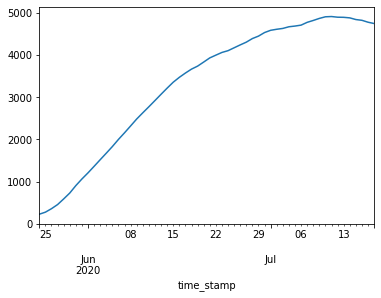

In [58]:
for region in read.regional_summary['region'].unique():
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_infected'].plot(label="current infected")
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_susceptible'].plot(label="current susceptible")
    plt.title(region)
    plt.legend()
    plt.show()

### Daily infections

In [59]:
summary = read.regional_summary.reset_index()

In [60]:
summary['time_stamp'][0].date()

datetime.date(2020, 5, 24)

In [61]:
def new_infections(summary):
    
    date = []
    for idx, row in summary.iterrows():
        date.append(row['time_stamp'].date())
    summary['date'] = date
    
    dates = np.unique(summary['date'])
    
    new_infections = []
    
    for date in dates:
        date_data = summary['daily_infected'][summary['date'] == date]
        new_infections.append(np.sum(date_data))
        
    return dates, new_infections

In [62]:
dates, new_infections = new_infections(summary)

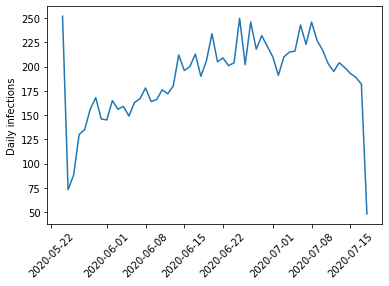

In [63]:
plt.plot(dates, new_infections)
plt.xticks(rotation=45)
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

In [64]:
def hospitalised(summary):
    date = []
    for idx, row in summary.iterrows():
        date.append(row['time_stamp'].date())
    summary['date'] = date
    
    dates = np.unique(summary['date'])
    
    hospitalised = []
    icu = []
    
    for date in dates:
        date_data = summary['current_hospitalised'][summary['date'] == date]
        hospitalised.append(np.sum(date_data))
        date_data = summary['current_intensive_care'][summary['date'] == date]
        icu.append(np.sum(date_data))
        
    return dates, hospitalised, icu

In [65]:
dates, hospitalised, icu = hospitalised(summary)

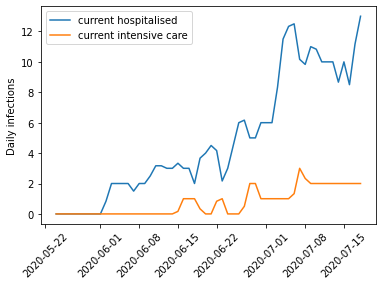

In [66]:
plt.plot(dates, hospitalised, label="current hospitalised")
plt.plot(dates, icu, label="current intensive care")
plt.xticks(rotation=45)
plt.ylabel('Daily infections')
plt.legend()
plt.show()

### Cumulative infections by age

In [67]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2021-10-28 12:22:59,917 - june.records.records_reader - INFO - Loading infections table
2021-10-28 12:22:59,942 - june.records.records_reader - INFO - Loading population table
2021-10-28 12:23:00,035 - june.records.records_reader - INFO - Merging infection and population tables
2021-10-28 12:23:00,056 - june.records.records_reader - INFO - Loading geography table
2021-10-28 12:23:00,111 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [68]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2021-10-28 12:23:00,212 - june.records.records_reader - INFO - Loading deaths table
2021-10-28 12:23:00,237 - june.records.records_reader - INFO - Loading population table
2021-10-28 12:23:00,327 - june.records.records_reader - INFO - Merging infection and population tables
2021-10-28 12:23:00,331 - june.records.records_reader - INFO - Loading geography table
2021-10-28 12:23:00,391 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [69]:
age_bins = (0,20,60,100)

In [70]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [71]:
people_df = read.table_to_df('population')

In [72]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

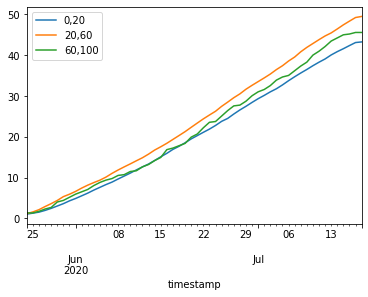

In [73]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.legend()

### Where people get infected

In [74]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

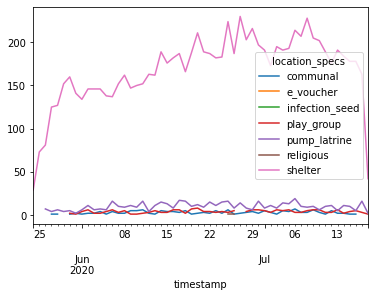

In [75]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

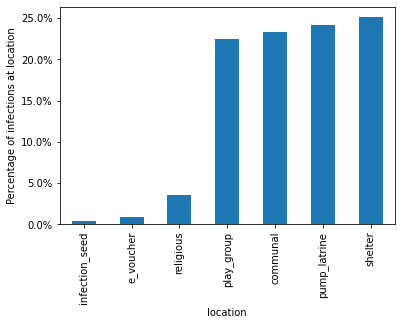

In [76]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')